# Use FFT Analysis of the Epileptor Time Series to Generate Times of Onset/Offset

Since peak detection on the z state variable is not very reliable, we may want to shift our algorithm of onset/offset time detection to a more complicated algorithm that looks at the signal itself, whether it is a frequency or amplitude space.

In [2]:
import numpy as np
import pandas as pd
import os

import sys
sys.path.append('./_tvblibrary/')
sys.path.append('./_tvbdata/')
sys.path.append('../')
from tvb.simulator.lab import *

import scipy.io
import tvbsim

np.random.seed(123456789)

# plotting fxns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

2018-04-25 16:48:49,498 - WARNING - tvb.simulator.common - psutil module not available: no warnings will be issued when a
    simulation may require more memory than available
   INFO  log level set to INFO


In [3]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y
def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='highpass', analog=False)
    return b, a
def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y
def overlap(start1, end1, start2, end2):
    """Does the range (start1, end1) overlap with (start2, end2)?"""
    return (
        start1 <= start2 <= end1 or
        start1 <= end2 <= end1 or
        start2 <= start1 <= end2 or
        start2 <= end1 <= end2
    )
def butter_lowpass_filter(data, highcut, fs, order=5):
    nyq = 0.5*fs
    highcut = highcut / nyq
    b, a = butter(order, highcut, btype='lowpass', analog=False)
    
    y = scipy.signal.filtfilt(b, a, data)
    return y

In [33]:
# set all directories
root_dir = os.path.join('/Users/adam2392/Documents/pydata/')
root_dir = os.path.join('/Volumes/ADAM LI/pydata/tvbforwardsim/')

# if on the cluster
# root_dir = os.path.join('/home/adamli/data/tvbforwardsim/')

patient='id008_gc'
patient ='id013_pg'
patient = 'id001_ac'
# expname = 'exp001'
expname = 'traindata/exp001'

datadir = os.path.join(root_dir, expname)
# Get ALL datafiles from all downstream files
datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        if '.DS' not in file:
            datafiles.append(os.path.join(root, file))
print(len(datafiles))
print(datafiles[0])

# helper functions for converting to unicode
decodebytes = lambda var: np.array([k.decode("utf-8").lower() if isinstance(k, bytes) else k for k in var])

116
/Volumes/ADAM LI/pydata/tvbforwardsim/traindata/exp001/id004_cv_dist-1.0.npz


In [34]:
tsviz = tvbsim.visualize.plotts.VisualTs()
counter = 0
for idx, datafile in enumerate(datafiles):
#     if 'id008' in datafile or 'id013' in datafile:
#         continue
#     counter +=1
#     if counter > 10:
#         break
    print(datafile)
    # load in the data for each simulation and run a large loop to visualize all the data
    npfile = open(datafile, 'r')
    data = np.load(npfile)
    epits = data['epits']
    seegts = data['seegts']
    times = data['times']
    zts = data['zts']
    metadata = data['metadata'].item()
    metadata = {k.decode("utf-8"): (v.decode("utf-8") if isinstance(v, bytes) else v) for k,v in metadata.items()}
    
#     print(metadata.keys())
#     print(metadata['epiparams'])
    ezind = metadata['ezindices']
    pzind = metadata['pzindices']
    seizonsets = metadata['onsettimes']
    seizoffsets = metadata['offsettimes']
    region_labels = metadata['regions']
    
    allinds = np.concatenate((ezind,pzind), axis=0)
    detector = tvbsim.detectonsetoffset.DetectShift()
    settimes = detector.getonsetsoffsets(epits, allinds)
    seizonsets, seizoffsets = detector.getseiztimes(settimes)
    
    # PLOTTING THE TIME SERIES OF THE SOURCE SIGNALS
#     tsviz.loaddata(data=epits,ylabels=region_labels)
#     # visualize seegts
#     tsviz.setfigsize(figsize=(40,35))
#     titlestr = datafile
# #     titlestr = 'ID004_CV Full Clin EZ/PZ TVB Simulation'
#     fig, ax = tsviz.plotts(normalize=True, titlestr=titlestr)
#     tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
#     tsviz.colorts(ezind, color='red')
#     tsviz.colorts(pzind, color='blue')
        
    metadata['seizonsets'] = seizonsets
    metadata['seizoffsets'] = seizoffsets

    # save tseries
#     np.savez_compressed(datafile, 
#                         epits=epits, 
#                         seegts=seegts, \
#                         times=times, 
#                         zts=zts, 
#                         metadata=metadata)
#     if 'id002' in datafile:
#         break
    
#     break

/Volumes/ADAM LI/pydata/tvbforwardsim/traindata/exp001/id004_cv_dist-1.0.npz
[21  2 26 22 20]
[    0.   235.   420.   678.  3160.  3322.  3580.  3812.  6283.  6659.
  6741.  6983.  9251.  9712.  9833. 10020. 12084. 12610. 12886. 12963.
 15490. 15890. 16012. 16168. 18369. 18873. 19140. 19513. 22150. 22614.
 22640. 22872. 25272. 25762. 25927. 26024. 28350. 28782. 29010. 29085.
 31092. 31838. 32147. 32166. 35211. 35455. 35570. 35768. 35845. 38534.
 38710. 39075. 39332. 39568.]
[  571.   906.   907.  1206.  3800.  4058.  4104.  4326.  6923.  7378.
  7233.  7527.  9853. 10158. 10552. 10537. 12700. 13096. 13440. 13632.
 16100. 16351. 16755. 16701. 18986. 19339. 19589. 20212. 22787. 23116.
 23377. 23414. 25886. 26221. 26630. 26549. 28927. 29242. 29704. 29617.
 31730. 32241. 32638. 32872. 35850. 36150. 36087. 36097. 36391. 39268.
 39397.    nan    nan    nan]
returning cuz prevoffset is nan!
/Volumes/ADAM LI/pydata/tvbforwardsim/traindata/exp001/id009_il_dist15.0.npz
[60 63 58 54 55]
[  518   

[21  2 26 22 20]


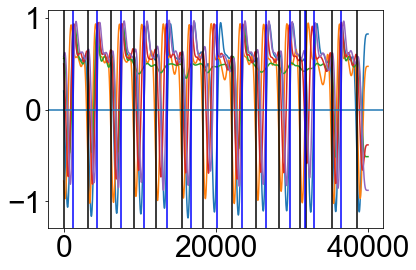

In [28]:
allinds = np.concatenate((ezind,pzind), axis=0)
print(allinds)
seiz_epi = epits[allinds,:]
highcut = 1
fs = 1000
seiz_epi = butter_lowpass_filter(seiz_epi, highcut, fs, order=5)
# seiz_epi = butter_highpass_filter(seiz_epi, 0.1, fs, order=5)

plt.figure()
for ind in range(len(allinds)):
#     seiz_epi[ind, :] = butter_lowpass_filter(seiz_epi[ind,:].squeeze(), highcut, fs, order=5)
    plt.plot(seiz_epi[ind,:])
    
# plt.axhline(np.mean(seiz_epi.ravel()))
plt.axhline(0)
for onset in seizonsets:
    plt.axvline(onset, color='k')
for offset in seizoffsets:
    plt.axvline(offset, color='b')

In [6]:
print("mean of signals are: ", np.mean(seiz_epi, axis=1))
print("Min of signals are: ", np.min(seiz_epi, axis=1))

('mean of signals are: ', array([0.10842847, 0.33764701, 0.50067036, 0.4561452 , 0.45929942]))
('Min of signals are: ', array([-1.6544585 , -1.5038991 ,  0.10925591, -1.46458696, -1.46042488]))


In [7]:
print(np.mean(np.mean(seiz_epi,axis=1)))
print(np.mean(np.min(seiz_epi, axis=1)))
print(np.floor(-2.02))

0.3724380932749308
-1.194822705457839
-3.0


In [26]:
print(seizonsets)
print(seizoffsets)
settimes = np.vstack((seizonsets, seizoffsets)).T
print(settimes)

# sort in place the settimes by onsets, since those will forsure have 1
settimes = settimes[settimes[:, 0].argsort()]

[4544, 33611, 12687, 17440, 20029]
[11024, nan, 17998, 20646, 22855]
[[ 4544. 11024.]
 [33611.    nan]
 [12687. 17998.]
 [17440. 20646.]
 [20029. 22855.]]


In [28]:
settimes = getsettimes(seiz_epi, allinds)
seizonsets, seizoffsets = getseiztimes(settimes)
print(seizonsets)
print(seizoffsets)

[ 4544. 12687. 17440. 20029. 33611.]
[11024. 17998. 20646. 22855.    nan]
returning cuz prevoffset is nan!
[4544.0, 12687.0, 33611.0]
[11024.0, 22855.0]


# Discussion

Here, we shifted our onset/offset algorithm to use the Epileptor time series instead. This "direct" access to the in-silico source signals is more then enough to generate a simple thresholding-based algorithm that is more robust then the peakdetection of the z state variable.

This will give the user an accurate onset/offset index for each dataset generated.

This was shifted into a function within the postprocess module